# DCGAN PyTorch

### Import Libraries

In [106]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.tensorboard import SummaryWriter

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


### Hyperparameters

In [107]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
z_dim = 64

# Number of training epochs
num_epochs = 5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Loading dataset

In [108]:
# load dataset
labels = np.load("../dataset/sprite_labels_nc_1788_16x16.npy")
data = np.load("../dataset/sprites_1788_16x16.npy")

print("Shape: ", data.shape)

images_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Convert HWC -> CHW
print("Shape (before permute): ", images_tensor.shape)
images_tensor = images_tensor.permute(0, 3, 1, 2)
print("Shape (after permute): ", images_tensor.shape)

dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)

Shape:  (89400, 16, 16, 3)
Shape (before permute):  torch.Size([89400, 16, 16, 3])
Shape (after permute):  torch.Size([89400, 3, 16, 16])
Device:  cuda:0


In [109]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Get one batch from the DataLoader
real_batch = next(iter(loader))  # real_batch[0]: images, real_batch[1]: labels

images, labels = real_batch
print(images.shape, labels.shape)

torch.Size([32, 3, 16, 16]) torch.Size([32, 5])


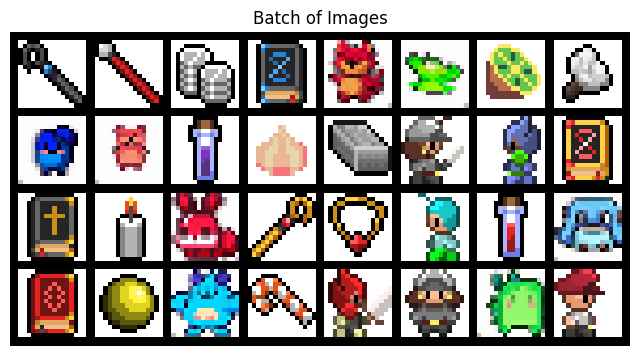

In [110]:
grid = vutils.make_grid(
    images,
    padding=2,
    normalize=True
)

'''
C: channels
H: height
W: width
B: batch size
'''
# CHW -> HWC for matplotlib
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch of Images")
plt.imshow(grid.numpy())
plt.show()

### Weights initialization

In [111]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   
        nn.init.constant_(m.bias.data, 0)

### Generator

In [112]:
# Size of feature maps in generator
ngf = 32

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.gen = nn.Sequential(
            # LAYER 1: The "Foundation" Layer
            # Input: (z_dim) x 1 x 1
            # Output: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(
                in_channels = z_dim,
                out_channels = ngf * 8,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False
            ),
            nn.BatchNorm2d(num_features = ngf * 8),
            nn.ReLU(inplace = True),
            
            # LAYER 2: First Upsample
            # Input: (ngf * 8) x 4 x 4
            # Output: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(
                in_channels = ngf * 8,
                out_channels = ngf * 4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(num_features = ngf * 4),
            nn.ReLU(inplace = True),
            
            # LAYER 3: Final Upsample to 16x16 Sprite
            # Input: (ngf * 4) x 8 x 8
            # Output: (nc) x 16 x 16
            nn.ConvTranspose2d(
                in_channels = ngf * 4,
                out_channels = nc,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)

In [113]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


### Discriminator

In [114]:
# Size of feature maps in discriminator
ndf = 32

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            # --- LAYER 1: THE INPUT LAYER ---
            # Input: (nc) x 16 x 16
            # Output: (ndf) x 8 x 8
            nn.Conv2d(
                in_channels  = nc,
                out_channels = ndf,
                kernel_size  = 4,
                stride       = 2, # Halves the dimension
                padding      = 1,
                bias         = False
            ),
            # Note: No BatchNorm in the first layer of the Discriminator (DCGAN rule)
            nn.LeakyReLU(0.2, inplace=True),

            # --- LAYER 2: THE COMPRESSION LAYER ---
            # Input: (ndf) x 8 x 8
            # Output: (ndf * 2) x 4 x 4
            nn.Conv2d(
                in_channels  = ndf,
                out_channels = ndf * 2,
                kernel_size  = 4,
                stride       = 2, # Halves the dimension
                padding      = 1,
                bias         = False
            ),
            nn.BatchNorm2d(num_features = ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # --- LAYER 3: THE CLASSIFICATION LAYER ---
            # Input: (ndf * 2) x 4 x 4
            # Output: 1 x 1 x 1 (A single probability score)
            nn.Conv2d(
                in_channels  = ndf * 2,
                out_channels = 1,
                kernel_size  = 4,
                stride       = 1, # No more downsampling
                padding      = 0,
                bias         = False
            ),
            nn.Sigmoid() # Outputs a value between 0 (Fake) and 1 (Real)
        )

    def forward(self, x):
        return self.disc(x)

In [115]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
)


### Loss Function and Optimizers

In [116]:
# Learning rate for optimizers
lrD = 0.002
lrG = 0.002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

In [117]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/2794]	Loss_D: 1.1750	Loss_G: 2.1618	D(x): 0.6900	D(G(z)): 0.5406 / 0.1246
[0/5][50/2794]	Loss_D: 1.6620	Loss_G: 2.7465	D(x): 0.7234	D(G(z)): 0.7213 / 0.0695
[0/5][100/2794]	Loss_D: 1.0648	Loss_G: 1.9269	D(x): 0.4760	D(G(z)): 0.2460 / 0.2213
[0/5][150/2794]	Loss_D: 1.2096	Loss_G: 1.6783	D(x): 0.5329	D(G(z)): 0.4079 / 0.1975
[0/5][200/2794]	Loss_D: 1.5705	Loss_G: 2.2969	D(x): 0.6079	D(G(z)): 0.6142 / 0.1104
[0/5][250/2794]	Loss_D: 1.0324	Loss_G: 1.7958	D(x): 0.5919	D(G(z)): 0.3581 / 0.1844
[0/5][300/2794]	Loss_D: 1.0846	Loss_G: 1.6321	D(x): 0.6622	D(G(z)): 0.4680 / 0.2108
[0/5][350/2794]	Loss_D: 1.2257	Loss_G: 1.1239	D(x): 0.4185	D(G(z)): 0.2356 / 0.3547
[0/5][400/2794]	Loss_D: 1.3289	Loss_G: 2.3548	D(x): 0.5877	D(G(z)): 0.5087 / 0.1102
[0/5][450/2794]	Loss_D: 1.4383	Loss_G: 1.4404	D(x): 0.4665	D(G(z)): 0.4316 / 0.2581
[0/5][500/2794]	Loss_D: 1.2064	Loss_G: 1.5652	D(x): 0.5762	D(G(z)): 0.4452 / 0.2219
[0/5][550/2794]	Loss_D: 1.2039	Loss_G: 1.6351	D(x): 0

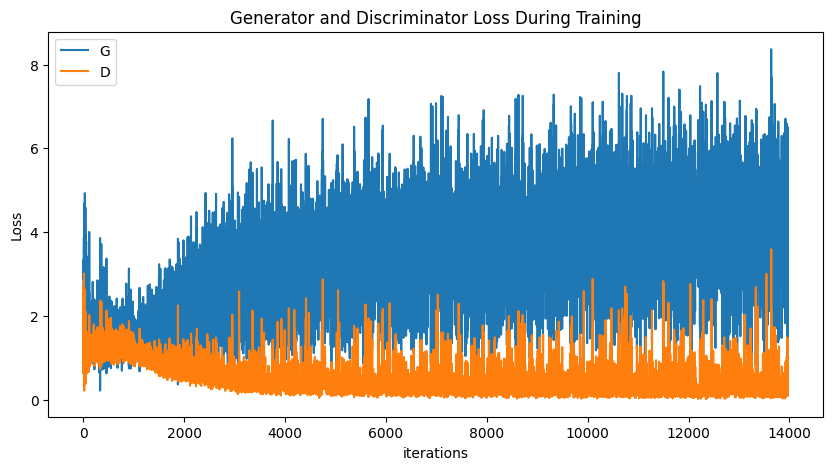

In [118]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

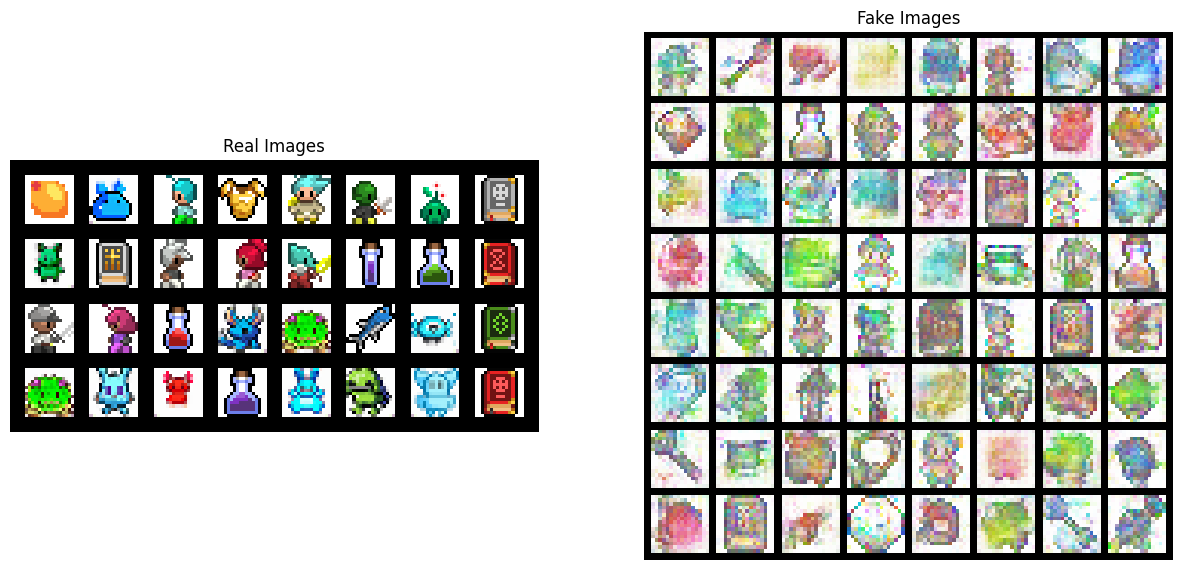

In [119]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

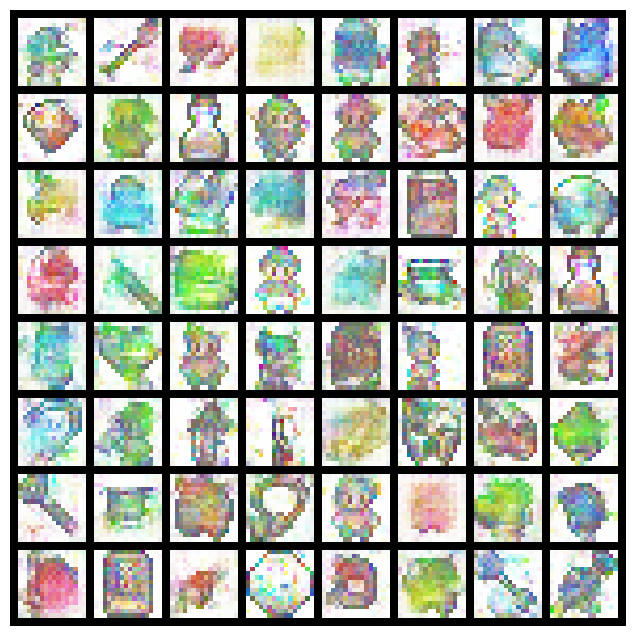

In [120]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())